# Simple orders analysis

🚀 We are finally ready to start analysing our `orders` dataset!

Our objective is to get an initial understanding of:
- `orders` properties
- their associated `review_scores`

In [14]:
# Import Modules 

import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt

In [15]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
# Import your newly coded _order_ training set
from olist.order import Order

# Change `with_distance_seller_customer` to False..if you have not completed the optional part of challenge 1 yet
orders = Order().get_training_data(with_distance_seller_customer=False)

In [17]:
# Check your shape below

# Shape if you set with_distance_seller_customer=True
if orders.shape[1] == 13: 
    assert(orders.shape == (95872, 13))

# Shape if you set with_distance_seller_customer=False    
else:  
    assert(orders.shape == (96353, 12))

## 1 - Inspect features

👉 Print summary statistics of each column of the order dataset (then focus in particular on `wait_time`)

In [18]:
print(orders['wait_time'].describe())

count    96353.000000
mean        12.522869
std          9.457183
min          0.533414
25%          6.763530
50%         10.211944
75%         15.685278
max        208.351759
Name: wait_time, dtype: float64


In [19]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96353 entries, 0 to 96360
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   order_id            96353 non-null  object 
 1   wait_time           96353 non-null  float64
 2   expected_wait_time  96353 non-null  float64
 3   delay_vs_expected   96353 non-null  float64
 4   order_status        96353 non-null  object 
 5   dim_is_five_star    96353 non-null  int64  
 6   dim_is_one_star     96353 non-null  int64  
 7   review_score        96353 non-null  int64  
 8   number_of_products  96353 non-null  int64  
 9   number_of_sellers   96353 non-null  int64  
 10  price               96353 non-null  float64
 11  freight_value       96353 non-null  float64
dtypes: float64(5), int64(5), object(2)
memory usage: 9.6+ MB


📈 Plot histograms to get a sense of the distribution of each numerical feature.

----- Distribution of wait_time : -----


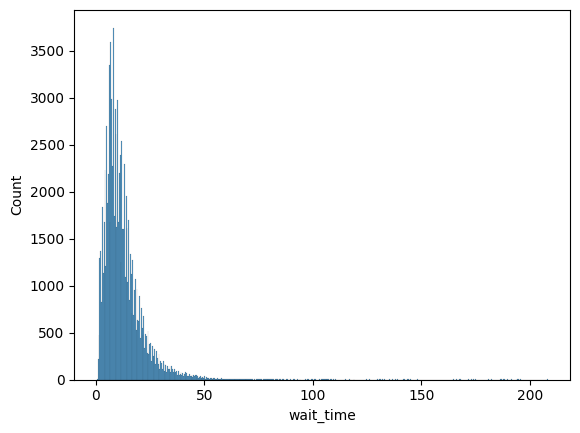

----- Distribution of expected_wait_time : -----


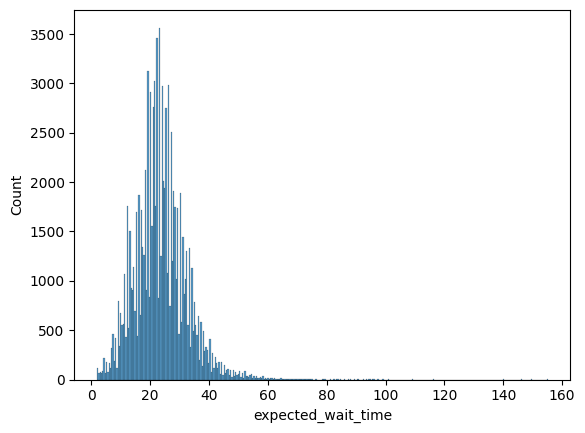

----- Distribution of delay_vs_expected : -----


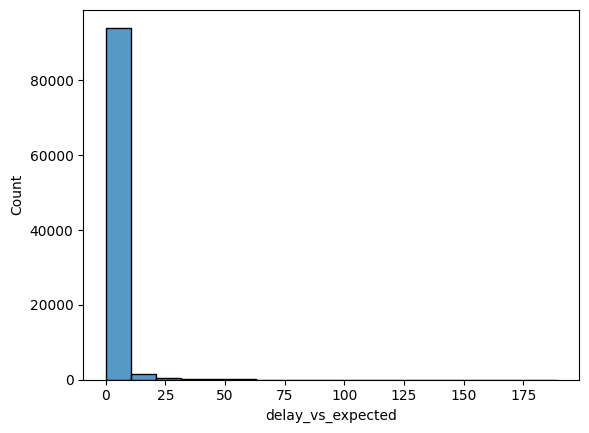

----- Distribution of dim_is_five_star : -----


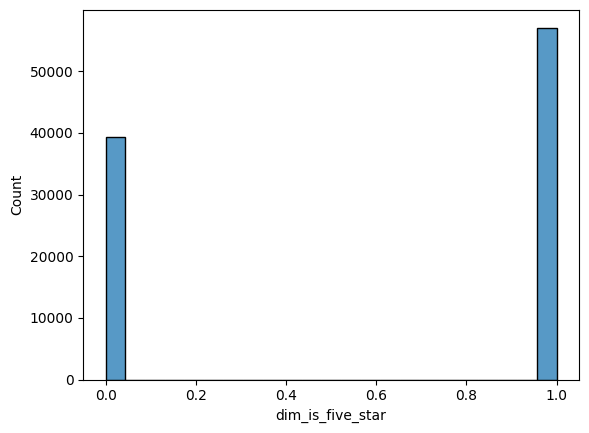

----- Distribution of dim_is_one_star : -----


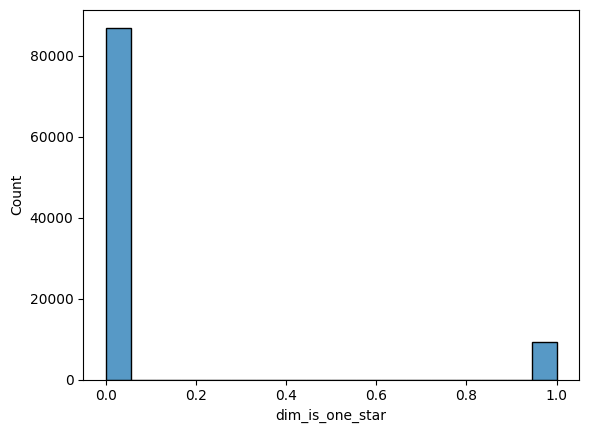

----- Distribution of review_score : -----


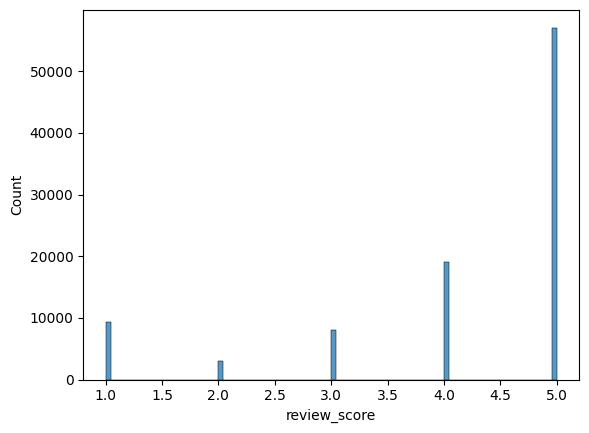

----- Distribution of number_of_products : -----


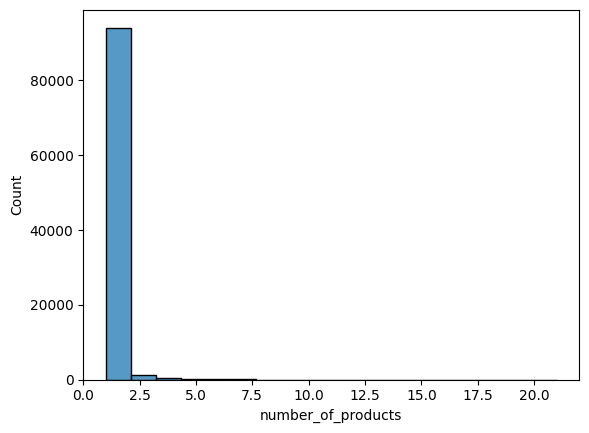

----- Distribution of number_of_sellers : -----


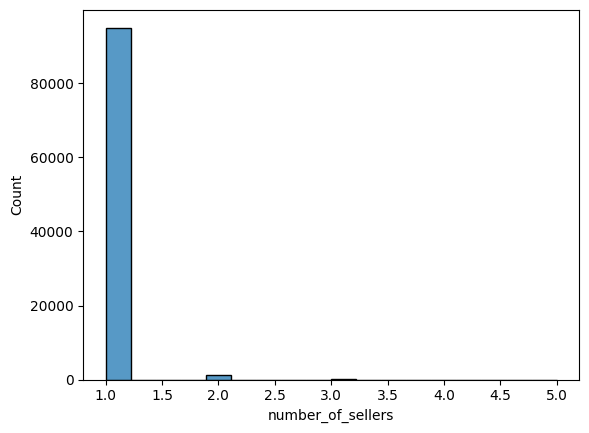

----- Distribution of price : -----


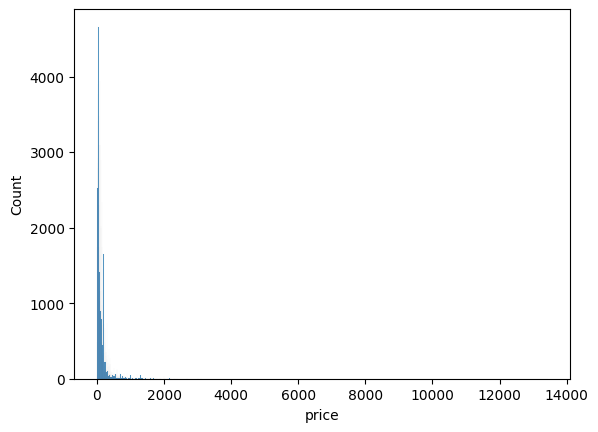

----- Distribution of freight_value : -----


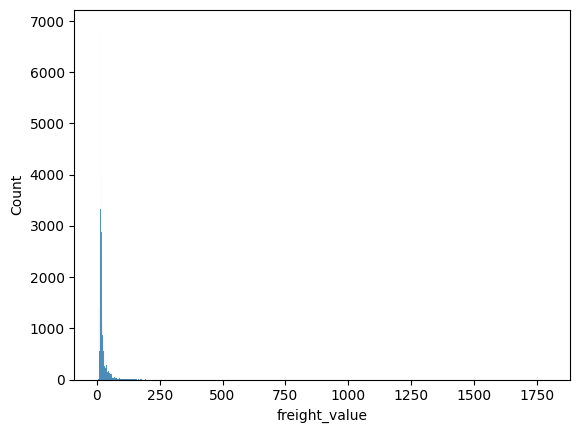

In [20]:
for variable in orders.select_dtypes(exclude = ["object"]).columns:
    print(f"----- Distribution of {variable} : -----")
    sns.histplot(orders[variable])
    plt.show()

👀 In particular, create a `sns.FacetGrid()` of histograms for each `review_score` vs. `wait_time`

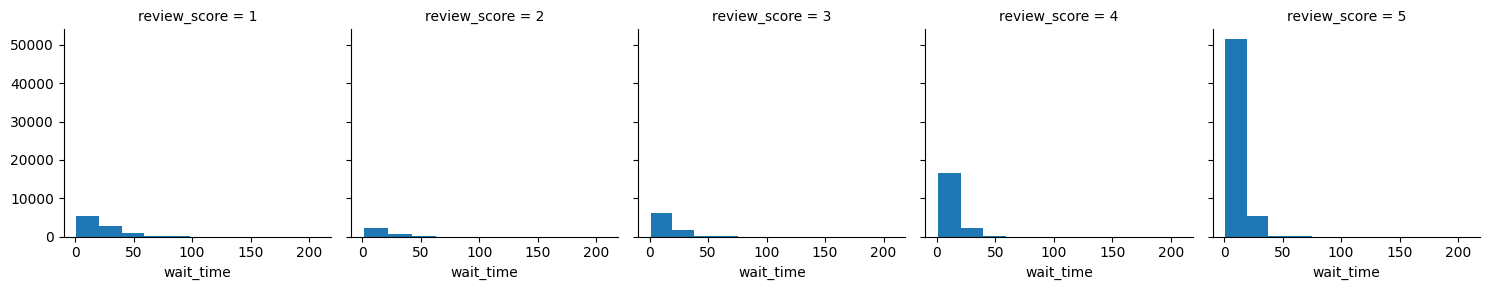

In [21]:
g = sns.FacetGrid(data=orders, col="review_score")
g.map(plt.hist, "wait_time")

❓ What do you notice for the variables `price` and `freight_value` ? 

❓ Have a look at the  `distance_seller_customer` feature if you have created it in `order.py`

In [22]:
matching_geo = Order().get_distance_seller_customer()

In [23]:
matching_geo['distance_seller_customer'].describe()

count    98177.000000
mean       601.961534
std        596.877838
min          0.000000
25%        186.380313
50%        433.698770
75%        798.435455
max       8736.947618
Name: distance_seller_customer, dtype: float64

<AxesSubplot:xlabel='price', ylabel='Density'>

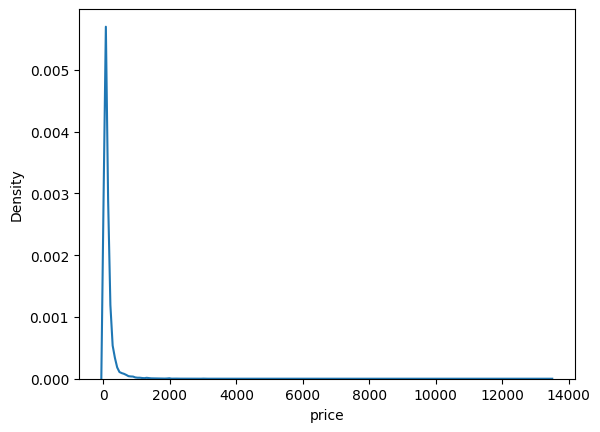

In [24]:
sns.kdeplot(orders['price'])

<AxesSubplot:xlabel='freight_value', ylabel='Density'>

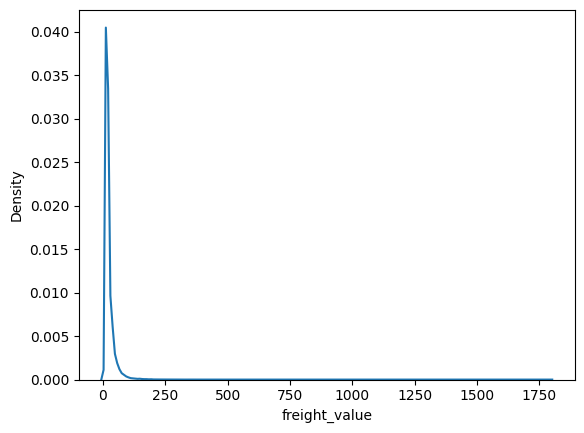

In [25]:
sns.kdeplot(orders['freight_value'])

In [26]:
# sns.kdeplot(orders['distance_seller_customer']) no working

KeyError: 'distance_seller_customer'

❓Inspect the various correlations between features: which feature seems to the most correlated with `review_score`?

<details>
    <summary>▸ Hint</summary>

* Use `DataFrame.corr()` combined with `sns.heatmap()` and `cmap='coolwarm'`
* Have a look at the absolute values of the correlation coefficients of `review_score` vs. each feature,
    * the higher the coefficient, the more one given feature is correlated (positively or negatively) with the `review_score`

</details>

<AxesSubplot:>

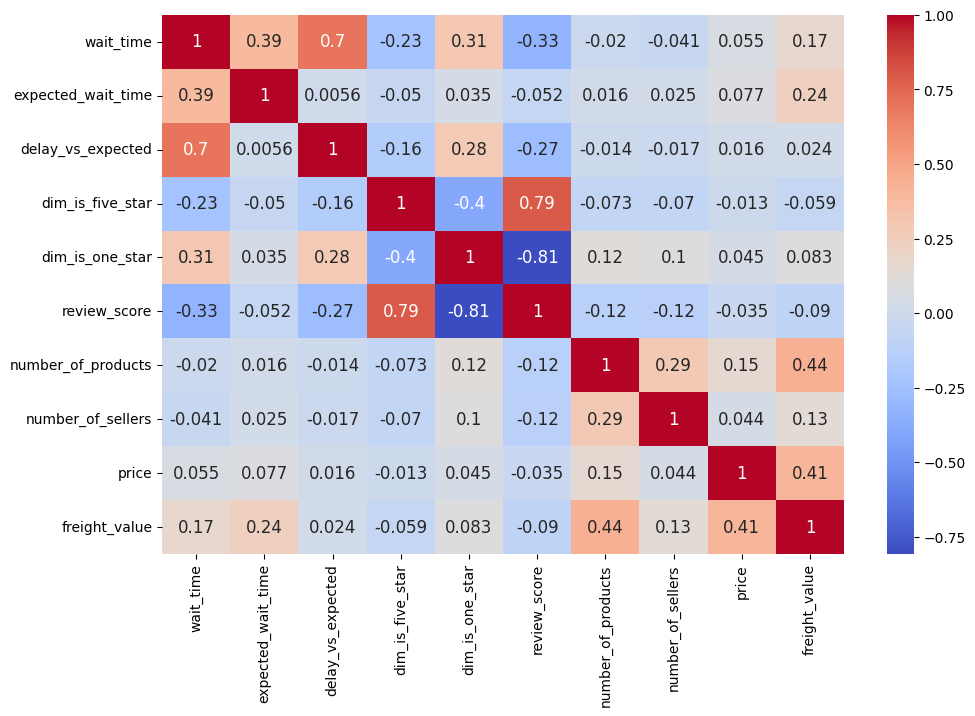

In [27]:
# Correlation plot 
plt.figure(figsize=(11,7))
sns.heatmap(orders.corr(), cmap='coolwarm', annot = True, annot_kws={"size": 12})

In [30]:
round(np.abs(orders.corr()['review_score']).sort_values(ascending = False),2)

review_score          1.00
dim_is_one_star       0.81
dim_is_five_star      0.79
wait_time             0.33
delay_vs_expected     0.27
number_of_products    0.12
number_of_sellers     0.12
freight_value         0.09
expected_wait_time    0.05
price                 0.03
Name: review_score, dtype: float64

In [31]:
round(orders.corr()['review_score'],2)

wait_time            -0.33
expected_wait_time   -0.05
delay_vs_expected    -0.27
dim_is_five_star      0.79
dim_is_one_star      -0.81
review_score          1.00
number_of_products   -0.12
number_of_sellers    -0.12
price                -0.03
freight_value        -0.09
Name: review_score, dtype: float64

* 😏 _Captain Obvious :_
    * `review_score` is 100% correlated to itself 
    * and strongly correlated to `dim_is_one_star` and `dim_is_five_star`...
* ⚠️ The two next highest correlation coefficients with respect to the `review_score` are :
    * `wait_time` : - 34 %
    * `delay_vs_expected` : - 27 %

## 2 - Simple regression of `review_score` against delivery duration

👉 So, it seems that `review_score` is mostly correlated with `wait_time` (= - 34%) and `delay_vs_expected` (- 27%).

🎨 Let's investigate these correlations  with `seaborn`

### 2.1 Plots
❓ In one figure, create 2 subplots, that regress `review_score` on `wait_time` and `delay_vs_expected` respectively.

<u>Tips</u>:

- Reduce your dataframe to a random sub-`sample of 10,000 rows` for speed purposes (a good practice in data exploration)
- Use `DataFrame.sample()` with a fixed `random_state` to avoid changing the sample at each execution if needed
- Use `sns.regplot()` to plot the `regression lines`
- Add some `y_jitter` parameters to better visualize the scatterplot density
- Limit `xlim` and `ylim` to hide outliers

In [32]:
sample = orders.sample(10000, random_state=42)

(0.0, 5.965706445225183)

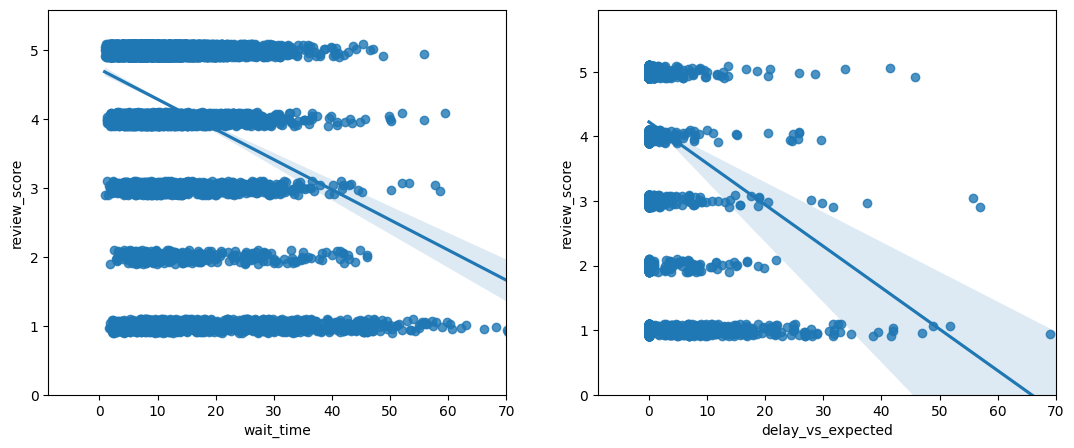

In [33]:
plt.figure(figsize=(13,5))

plt.subplot(1,2,1)
sns.regplot(x = sample.wait_time, y= sample.review_score, y_jitter=.1)
plt.xlim(right=70)
plt.ylim(bottom=0)

plt.subplot(1,2,2)
sns.regplot(x = sample.delay_vs_expected, y= sample.review_score, y_jitter=.1)
plt.xlim(right=70)
plt.ylim(bottom=0)

ℹ️ What did `regplot` do ? 

👉 It tried to perform a `Linear Regression` of the `review_score` vs. `wait_time` and `delay_vs_exp` <br/> *(Cf. Day 03 - Linear Regression tomorrow)*

🧐 It doesn't look so interpretable, does it ?

👉 You are right: we have only 5  different review scores which can be interpreted as a categorical variable with five different possible values (for example: "very bad", "bad", "average", "good" and "very good") that we are trying to regress against two continuous values that are `wait_time` and `delay_vs_exp`.

👀 However, based on the regression lines, we can see a very intuitive pattern: the longer the waiting time and/or the delay, the lower the review score - Well, not surprising. But how fast does the review score decrease ?


### 2.2 Interpretation

❓Try to visually "compute" the `slope` of each curve. 

✍️ Write down, in plain English, how you would interpret these coefficients if you were to explain it to a non-data-educated audience.

> YOUR ANSWER HERE

<details>
    <summary>▸ Answer</summary>


- `Slope wait_time ≈ -0.05` : "For each additional day waiting for an order to be delivered, the review score on average is reduced by 0.05"
- `Slope delay ≈ -0.1` : "For each additional day waiting for an order to be delivered _after the ETA_, the review score on average is reduced by 0.1"

❓ Are you surprised that the delay seems more impactful than the waiting time ? 
    
👉If yes, think about it twice: you may be impatient to receive your order and would like a small wait time, but you would be even more disappointed to receive your package after the expected delivery date !
        
</details>

### 2.3 Inferential analysis

Even if we had used all 100,000 orders for these regplots, these orders represent 16 months of data after all...

⚠️⚠️⚠️ **How certain** are we that these coefficients are **statistically significant**? ⚠️⚠️⚠️

⚡️ <u> Questions about the statistical significance of these coefficients: </u>

* Are these coefficients able to generalize well to future orders (all else being equal) ? (*Ideal answer: Yes*) 
* Are we sure that these coefficients do not simply capture random fluctuations due to the limited observation period ? (*Ideal answer: No*) 

🧐 We need to estimate the **`confidence interval`** around the mean value for these two slopes  :
$$slope_{wait} = -0.05 ± \ ?? \ \text{[95% interval]} $$
$$slope_{delay} = -0.1 ± \ ?? \ \text{[95% interval]} $$

⭐️ Fortunately, `Seaborn` already computes this 95% confidence interval for us with a shaded blue cone around the regression line!

❓Use `Seaborn` `regplot` to visualize the two confidence intervals:
- Change the `size of your sample dataset`: 
    - Notice how the slope may change as the sample size becomes smaller. 
    - What about the confidence interval?
- Change the `size of the confidence interval` by playing with the regplot parameter called `ci` (95% by default)

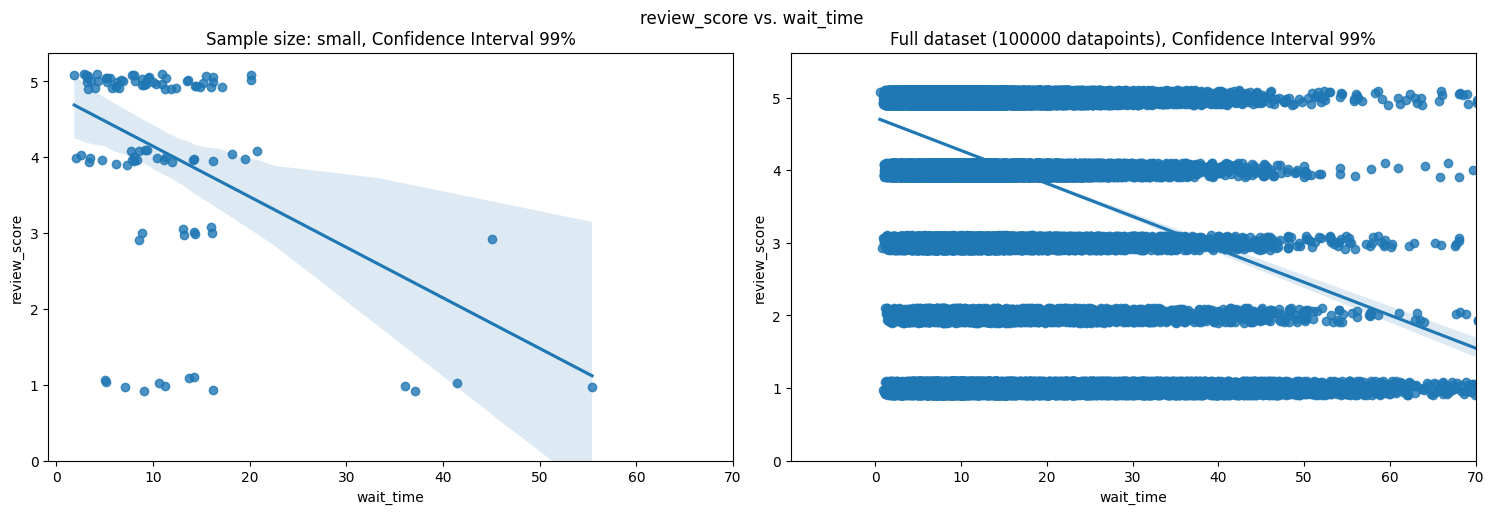

In [34]:
sample = orders.sample(100, random_state=42)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

fig.suptitle('review_score vs. wait_time')
fig.tight_layout()

sns.regplot(x = sample.wait_time, y= sample.review_score, y_jitter=.1, ci=99, ax = axes[0])
axes[0].set_xlim(right=70)
axes[0].set_ylim(bottom=0)
axes[0].set_title("Sample size: small, Confidence Interval 99%")


sns.regplot(x = orders.wait_time, y= orders.review_score, y_jitter=.1, ci=99, ax = axes[1])
axes[1].set_xlim(right=70)
axes[1].set_ylim(bottom=0)
axes[1].set_title("Full dataset (100000 datapoints), Confidence Interval 99%")

plt.show();

🔎 Interpretation:

* **Null Hypothesis** $H_0$ : "this variable does not influence the review score", a.k.a its coefficient is equal to zero

When plotting all our datapoints:
- The 95% confidence interval for the slope does not contain the value 0.
    - 👉 We are `95% confident that slower deliveries are associated with weaker reviews`.
- The **`p-value`** associated with the null hypothesis "the impact of delivery time on review scores is almost zero" is lower than 5%
    - 👉 We can safely reject this null hypothesis and consider the **`alternative hypothesis`** = `"the delivery time has an impact on the review score"` 

🔥 Our findings are said to be **statistically significant**. 

⚠️ However, **correlation does NOT imply causality**. 

- It can be inherently slower to deliver certain products (e.g.heavy products)
    - These categories of products will often have a low review_score, not matter how long their delivery time is. 

👉 Identifying **confounding factor** is crucial and cannot be done with a simple univariate regression. 

🗓 Cf. `Lecture 3 - Linear Regression` : we will talk about **`multivariate linear regression`**. 
</details>



---
🏁 Congratulations! 

🙏 Don't forget to `commit` and `push` your notebook